# Project - Environmental analysis

In [ ]:
!pip install geopandas
!pip install rasterio
!pip install fiona

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 71.9 MB/s eta 0:00:00


In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Import other required packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import seaborn as sns
import warnings
import geopandas as gpd
import fiona
fiona.drvsupport.supported_drivers['ESRI Shapefile'] = 'rw'
fiona.Env(OSR_WKT_FORMAT="WKT2_2019", SHAPE_RESTORE_SHX="YES")


# Basic settings
warnings.filterwarnings('ignore')
sns.set_theme(style="whitegrid")



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

# Correct project base directory (based on your Google Drive structure)
BASE_DIR = "/content/drive/MyDrive/Colab Notebooks/Environment_analysis/"
GLACIAL_LAKES_DIR = os.path.join(BASE_DIR, "glacial_lakes/")

print(" Environment Ready!")
print(f"Glacial Lakes Files: {os.listdir(GLACIAL_LAKES_DIR)}")



 Environment Ready!
Glacial Lakes Files: ['glims_polygons.shx', 'glims_polygons.shp', 'glims_points.shx', 'glims_images.shp', 'glims_images.shx', 'glims_images.dbf', 'glims_lines.shp', 'glims_lines.prj', 'glims_hypsometry_50.csv', 'README.txt', 'glims_polygons.dbf', 'glacial_lakes_final.geojson', 'glacial_lakes_cleaned.csv']


In [ ]:
# --- Load Shapefiles ---

# Load polygons shapefile
polygon_fp = os.path.join(GLACIAL_LAKES_DIR, "glims_polygons.shp")
gdf_polygons = gpd.read_file(polygon_fp)


print(f" Loaded {len(gdf_polygons)} polygon features.")
gdf_polygons.head()


 Loaded 914591 polygon features.


line_type   anlys_id         glac_id           anlys_time      area  \
0  intrnl_rock   407187.0  G220886E60666N  2015-07-16T00:00:00  1053.720   
1  intrnl_rock   407187.0  G220886E60666N  2015-07-16T00:00:00  1053.720   
2  intrnl_rock   416449.0  G229065E56877N  2015-07-16T00:00:00     1.038   
3   glac_bound   715234.0  G340953E63564N  1993-09-01T00:00:00    12.414   
4   glac_bound  1048878.0  G306386E70153N  2020-09-09T00:00:00     0.000   

      db_area  width  length  primeclass  min_elev  ...  gtng_o2reg  \
0  1053.72000    0.0     0.0         0.0     752.0  ...         5.0   
1  1053.72000    0.0     0.0         0.0     752.0  ...         5.0   
2     1.03769    0.0     0.0         0.0    1226.0  ...         6.0   
3    12.41360    0.0     0.0         0.0     405.0  ...         1.0   
4    14.93300    0.0     0.0         0.0       0.0  ...         1.0   

   rgi_gl_typ       parent_id loc_unc_x loc_unc_y glob_unc_x glob_unc_y  \
0          99            None        50        50         80         80   
1          99            None        50        50         80         80   
2          99  G229060E56875N        50        50         80         80   
3        None  G340925E63656N        50        50         80         80   
4        None            None        50        50         80         80   

               submitters                                           analysts  \
0          Cogley, Graham  Beedle, Matthew; Berthier, Etienne; Bolch, Tob...   
1          Cogley, Graham  Beedle, Matthew; Berthier, Etienne; Bolch, Tob...   
2          Cogley, Graham  Beedle, Matthew; Berthier, Etienne; Bolch, Tob...   
3       Sigurdsson, Oddur                                  Sigurdsson, Oddur   
4  Carrivick, Jonathan L.                             Carrivick, Jonathan L.   

                                            geometry  
0  POLYGON Z ((-138.9058 60.51773 0, -138.90541 6...  
1  POLYGON Z ((-139.08815 60.56706 0, -139.08641 ...  
2  POLYGON Z ((-130.94101 56.87622 0, -130.94059 ...  
3  POLYGON Z ((-19.04472 63.58378 0, -19.04474 63...  
4  POLYGON Z ((-53.67435 70.18178 0, -53.66553 70...  

[5 rows x 40 columns]

In [ ]:
# --- CRS Assignment ---
# If CRS is missing, assign EPSG:4326 (WGS84)
if gdf_polygons.crs is None:
    print(" CRS missing! Assigning EPSG:4326...")
    gdf_polygons = gdf_polygons.set_crs(epsg=4326)
else:
    print(f" CRS found: {gdf_polygons.crs}")

# --- Spatial Filtering: Keep Only Nepal Region  ---

# Use centroid of each polygon
gdf_polygons = gdf_polygons[
    (gdf_polygons.geometry.centroid.x >= 80) & (gdf_polygons.geometry.centroid.x <= 89) &
    (gdf_polygons.geometry.centroid.y >= 26) & (gdf_polygons.geometry.centroid.y <= 31)
]

print(f" After Nepal spatial filtering: {len(gdf_polygons)} glacial lakes retained.")


# --- Step 1: Create Year Column ---

# If 'src_date' exists, extract year
if 'src_date' in gdf_polygons.columns:
    gdf_polygons['src_date'] = pd.to_datetime(gdf_polygons['src_date'], errors='coerce')
    gdf_polygons['year'] = gdf_polygons['src_date'].dt.year
    print(" Year column created successfully from 'src_date'.")
else:
    raise ValueError(" 'src_date' field not found. Cannot create 'year'.")

# --- Step 2: Calculate Area in sqkm ---

# Project to UTM Zone 45N for correct area calculation (Nepal)
gdf_projected = gdf_polygons.to_crs(epsg=32645)

# Calculate area in square meters ➔ convert to sq km
gdf_polygons['area_sqkm'] = gdf_projected.geometry.area / 10**6
print(" Area_sqkm field calculated successfully.")



 CRS found: EPSG:4326
 After Nepal spatial filtering: 41229 glacial lakes retained.
 Year column created successfully from 'src_date'.
 Area_sqkm field calculated successfully.


In [ ]:
# --- Quick Overview ---
print(f"\n Loaded {len(gdf_polygons)} polygon features.")
print(gdf_polygons.info())
print(" Columns:", gdf_polygons.columns.tolist())


 Loaded 41229 polygon features.
<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 41229 entries, 47186 to 905856
Data columns (total 42 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   line_type   41229 non-null  object        
 1   anlys_id    41229 non-null  float64       
 2   glac_id     41229 non-null  object        
 3   anlys_time  41229 non-null  object        
 4   area        41229 non-null  float64       
 5   db_area     41229 non-null  float64       
 6   width       41229 non-null  float64       
 7   length      41229 non-null  float64       
 8   primeclass  41229 non-null  float64       
 9   min_elev    41229 non-null  float64       
 10  mean_elev   41229 non-null  float64       
 11  max_elev    41229 non-null  float64       
 12  src_date    36263 non-null  datetime64[ns]
 13  rec_status  41229 non-null  object        
 14  glac_name   41229 non-null  object        
 15  wgms_id     41229 non-null  o

In [ ]:
# --- Data Cleaning ---

# Normalize column names
gdf_polygons.columns = (
    gdf_polygons.columns
    .str.strip()
    .str.lower()
    .str.replace(' ', '_')
)

In [ ]:
# Handle Missing Values
missing_summary = gdf_polygons.isnull().sum()
print("\n Missing values per column:\n", missing_summary)

# Drop invalid or empty geometries
gdf_polygons = gdf_polygons[gdf_polygons.is_valid]
gdf_polygons = gdf_polygons[~gdf_polygons.geometry.is_empty]
print(f" Valid geometries retained: {len(gdf_polygons)}")


 Missing values per column:
 line_type        0
anlys_id         0
glac_id          0
anlys_time       0
area             0
db_area          0
width            0
length           0
primeclass       0
min_elev         0
mean_elev        0
max_elev         0
src_date      4966
rec_status       0
glac_name        0
wgms_id          0
local_id         0
glac_stat        0
gone_date        0
gone_dt_e        0
subm_id          0
release_dt       0
proc_desc        0
rc_id            0
geog_area        0
chief_affl       0
conn_lvl         0
surge_type       0
term_type        0
gtng_o1reg       0
gtng_o2reg       0
rgi_gl_typ       0
parent_id        0
loc_unc_x        0
loc_unc_y        0
glob_unc_x       0
glob_unc_y       0
submitters       0
analysts         0
geometry         0
year          4966
area_sqkm        0
dtype: int64
 Valid geometries retained: 41229


In [ ]:
# --- Export Cleaned CSV ---

output_csv = os.path.join(GLACIAL_LAKES_DIR, "glacial_lakes_cleaned.csv")
gdf_polygons.to_csv(output_csv, index=False)
print(f" Cleaned dataset exported to:\n{output_csv}")


 Cleaned dataset exported to:
/content/drive/MyDrive/Colab Notebooks/Environment_analysis/glacial_lakes/glacial_lakes_cleaned.csv


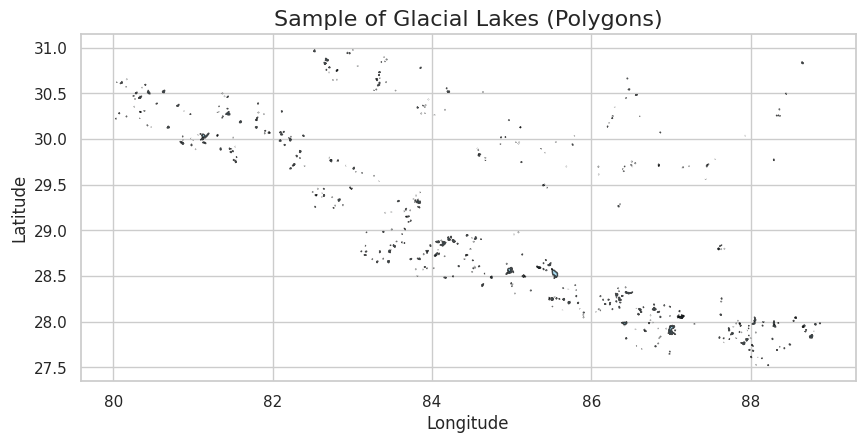

In [ ]:
# --- Quick Visualization ---

# Plot sample of glacial lakes
fig, ax = plt.subplots(figsize=(10, 8))
gdf_polygons.sample(min(500, len(gdf_polygons))).plot(ax=ax, color='skyblue', edgecolor='black', alpha=0.7)
ax.set_title('Sample of Glacial Lakes (Polygons)', fontsize=16)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

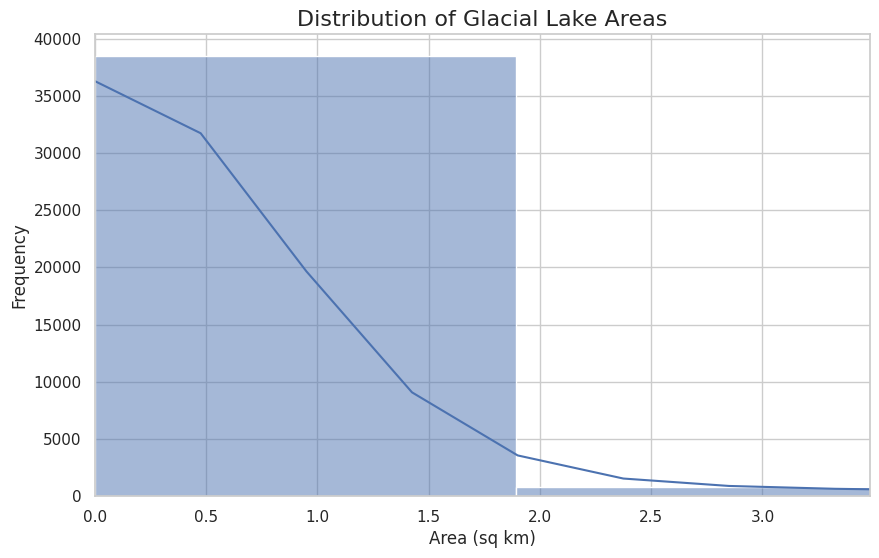

In [ ]:
# --- Area Analysis ---

if 'area' in gdf_polygons.columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(gdf_polygons['area'].dropna(), bins=50, kde=True)
    plt.title('Distribution of Glacial Lake Areas', fontsize=16)
    plt.xlabel('Area (sq km)')
    plt.ylabel('Frequency')
    plt.xlim(0, gdf_polygons['area'].quantile(0.95))  # Focus on 95th percentile
    plt.show()
else:
    print(" No 'area' field found. We can calculate area manually if needed.")


In [ ]:
# --- Validation Checks ---

# Check and fix CRS again if needed
if gdf_polygons.crs != "EPSG:4326":
    print(f" CRS is {gdf_polygons.crs}, reprojecting to EPSG:4326...")
    gdf_polygons = gdf_polygons.to_crs(epsg=4326)
    print(" Reprojection completed.")

In [ ]:
# Check invalid geometries
invalid_geoms = gdf_polygons[~gdf_polygons.is_valid]
print(f" Invalid geometries found: {len(invalid_geoms)}")

 Invalid geometries found: 0


In [ ]:
# --- Save Final Clean GeoJSON ---
final_output = os.path.join(GLACIAL_LAKES_DIR, "glacial_lakes_final.geojson")
gdf_polygons.to_file(final_output, driver='GeoJSON')
print(f" Final cleaned GeoJSON exported to:\n{final_output}")

 Final cleaned GeoJSON exported to:
/content/drive/MyDrive/Colab Notebooks/Environment_analysis/glacial_lakes/glacial_lakes_final.geojson


#  2: Glacial Lake Area Calculation, Time Series Analysis

In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.colors import Normalize
import os
from matplotlib import cm

In [ ]:
print(gdf_polygons.columns.tolist())
# Check if 'year' and 'area_sqkm' really have values

print(gdf_polygons[['year', 'area_sqkm']].head())
print(f"Unique years found: {gdf_polygons['year'].dropna().unique()}")
print(f"Minimum year: {gdf_polygons['year'].min()}, Maximum year: {gdf_polygons['year'].max()}")



['line_type', 'anlys_id', 'glac_id', 'anlys_time', 'area', 'db_area', 'width', 'length', 'primeclass', 'min_elev', 'mean_elev', 'max_elev', 'src_date', 'rec_status', 'glac_name', 'wgms_id', 'local_id', 'glac_stat', 'gone_date', 'gone_dt_e', 'subm_id', 'release_dt', 'proc_desc', 'rc_id', 'geog_area', 'chief_affl', 'conn_lvl', 'surge_type', 'term_type', 'gtng_o1reg', 'gtng_o2reg', 'rgi_gl_typ', 'parent_id', 'loc_unc_x', 'loc_unc_y', 'glob_unc_x', 'glob_unc_y', 'submitters', 'analysts', 'geometry', 'year', 'area_sqkm']
         year  area_sqkm
47186  2004.0   3.962112
47187  2009.0   0.318959
47196  2004.0   0.132055
47201  2009.0   0.017158
47207  2006.0   0.181549
Unique years found: [2004. 2009. 2006. 2002. 1999. 2001. 2007. 2010. 2008. 2011. 2005. 1974.
 1975. 1966. 2000. 1982. 1967. 1964. 1965. 1968. 1970. 1963. 1962. 1960.
 1959. 1978. 1994. 1998. 1992.]
Minimum year: 1959.0, Maximum year: 2011.0


In [ ]:
# --- Confirm Dataset Ready ---

# Make sure 'year' and 'area_sqkm' fields exist
assert 'year' in gdf_polygons.columns, "Missing 'year' column!"
assert 'area_sqkm' in gdf_polygons.columns, "Missing 'area_sqkm' column!"


In [ ]:


# Filter to 1980-2022
gdf_polygons = gdf_polygons[
    (gdf_polygons['year'] >= 1980) &
    (gdf_polygons['year'] <= 2022)
]

# Prepare list of years
years = sorted(gdf_polygons['year'].dropna().astype(int).unique())
print(f" Years available for animation: {years}")



# Prepare cumulative total area
cumulative_area = (
    gdf_polygons
    .dropna(subset=['year'])
    .groupby('year')
    .agg(total_area_sqkm=('area_sqkm', 'sum'))
    .cumsum()
    .reset_index()
)

 Years available for animation: [np.int64(1982), np.int64(1992), np.int64(1994), np.int64(1998), np.int64(1999), np.int64(2000), np.int64(2001), np.int64(2002), np.int64(2004), np.int64(2005), np.int64(2006), np.int64(2007), np.int64(2008), np.int64(2009), np.int64(2010), np.int64(2011)]


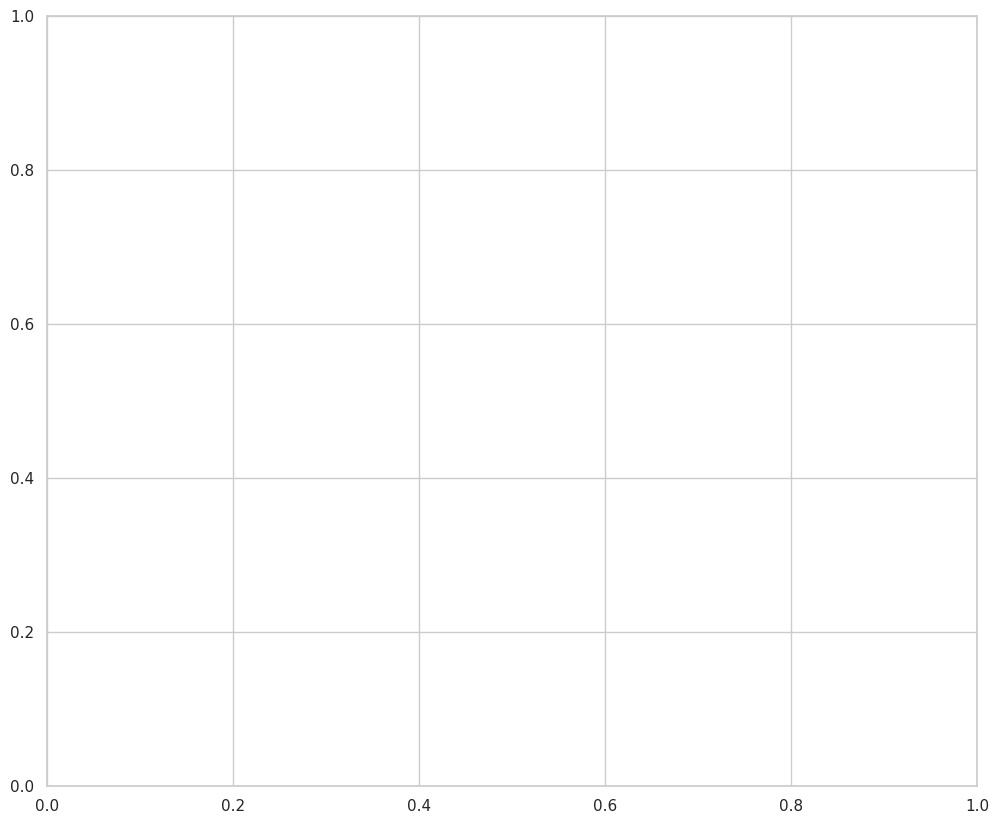

In [ ]:
# --- Set up Figure ---

fig, ax = plt.subplots(figsize=(12, 10))

norm = Normalize(vmin=min(years), vmax=max(years))
cmap = cm.plasma

frames_exist = False  # Track if any frame is generated

# Animation

In [ ]:
import geopandas as gpd

# Path to your uploaded Nepal GeoJSON
nepal_geojson_path = "/content/drive/MyDrive/Colab Notebooks/Environment_analysis/nepal-districts-new.geojson"

# Load Nepal districts
nepal = gpd.read_file(nepal_geojson_path)

print(f" Loaded Nepal districts GeoJSON with {len(nepal)} district geometries.")


 Loaded Nepal districts GeoJSON with 77 district geometries.


In [ ]:
# Create centroids for label placement
nepal['centroid'] = nepal.geometry.centroid

# Extract X and Y
nepal['centroid'] = nepal.geometry.centroid
nepal['centroid_x'] = nepal['centroid'].x
nepal['centroid_y'] = nepal['centroid'].y


In [ ]:
# --- Update Function ---

def update(frame_year):
    global frames_exist
    ax.clear()

    subset = gdf_polygons[gdf_polygons['year'] <= frame_year]

    if len(subset) == 0:
        return  # Skip if no lakes to plot

    frames_exist = True  # At least one frame plotted!

    # --- Plot Nepal districts basemap ---
    nepal.boundary.plot(ax=ax, color='black', linewidth=0.5)

    # --- Plot district names ---
    for idx, row in nepal.iterrows():
        ax.text(row['centroid_x'], row['centroid_y'],
                row['DIST_EN'], fontsize=6, ha='center', va='center',
                color='darkgreen', fontweight='bold', alpha=0.7)

    # --- Plot lakes ---
    subset['color'] = subset['year'].apply(lambda y: cmap(norm(y)))
    subset.plot(ax=ax, color=subset['color'], edgecolor='black', linewidth=0.3, alpha=0.7)



    # Titles
    ax.set_title(f' Glacial Lake Expansion up to {frame_year}', fontsize=20)
    ax.set_xlabel('Longitude', fontsize=14)
    ax.set_ylabel('Latitude', fontsize=14)
    ax.grid(True)

    # Total Area Counter
    if frame_year in cumulative_area['year'].values:
        total_area = cumulative_area[cumulative_area['year'] == frame_year]['total_area_sqkm'].values[0]
        ax.text(0.02, 0.95, f'Total Area: {total_area:.1f} km²',
                transform=ax.transAxes, fontsize=16, color='navy',
                bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'))

    # Colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, orientation="vertical", fraction=0.036, pad=0.04)
    cbar.set_label('Acquisition Year', fontsize=12)

# --- Create Animation ---

ani = animation.FuncAnimation(
    fig, update, frames=years, repeat=False, interval=500
)



In [ ]:
# --- Save Animation ---

# IMPORTANT: Only save if frames exist
if frames_exist:
    # Save as GIF
    gif_output_path = os.path.join(GLACIAL_LAKES_DIR, "glacial_lake_expansion.gif")
    ani.save(gif_output_path, writer='pillow', fps=2)

    # Save as MP4
    mp4_output_path = os.path.join(GLACIAL_LAKES_DIR, "glacial_lake_expansion.mp4")
    ani.save(mp4_output_path, writer='ffmpeg', fps=2)

    print(f" Animation saved successfully!\nGIF: {gif_output_path}\nMP4: {mp4_output_path}")
else:
    print(" No frames available for animation. Please check the data!")

# --- Show Animation Inline (Colab) ---
from IPython.display import HTML
HTML(ani.to_jshtml())

 Animation saved successfully!
GIF: /content/drive/MyDrive/Colab Notebooks/Environment_analysis/glacial_lakes/glacial_lake_expansion.gif
MP4: /content/drive/MyDrive/Colab Notebooks/Environment_analysis/glacial_lakes/glacial_lake_expansion.mp4


<Figure size 640x480 with 0 Axes>

In [ ]:
import geopandas as gpd

# Make sure CRS (Coordinate Reference System) matches
if nepal.crs != gdf_polygons.crs:
    print("CRS mismatch detected! Reprojecting glacial lakes to match Nepal boundary...")
    gdf_polygons = gdf_polygons.to_crs(nepal.crs)

# Perform spatial join: which lakes fall inside which district
lakes_with_districts = gpd.sjoin(gdf_polygons, nepal, how='inner', predicate='intersects')

print(f" Found {len(lakes_with_districts)} lakes matched to districts.")


 Found 12016 lakes matched to districts.


In [ ]:
# Group by district name and count
lake_counts = lakes_with_districts.groupby('DIST_EN').size().reset_index(name='lake_count')

# Merge counts back into Nepal GeoDataFrame
nepal = nepal.merge(lake_counts, how='left', on='DIST_EN')

# Fill NaN lake counts with 0
nepal['lake_count'] = nepal['lake_count'].fillna(0).astype(int)

print(" Lake counts merged into Nepal districts:")
print(nepal[['DIST_EN', 'lake_count']].head())


 Lake counts merged into Nepal districts:
        DIST_EN  lake_count
0        Achham           0
1  Arghakhanchi           0
2       Baglung           0
3       Baitadi           0
4       Bajhang         648


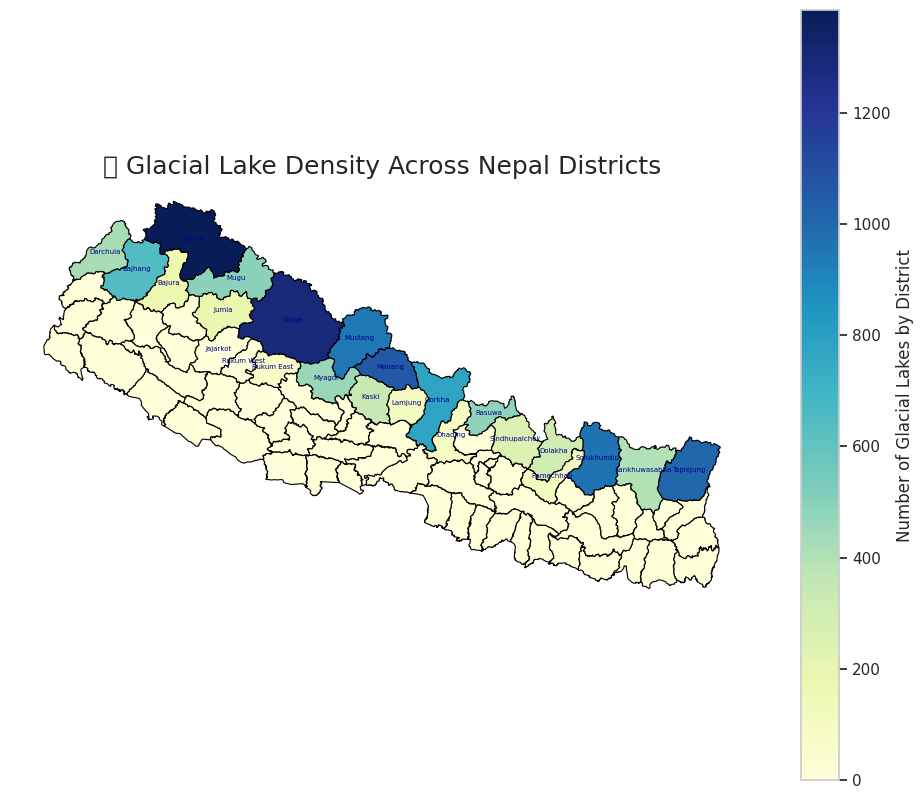

In [ ]:
import matplotlib.pyplot as plt

# Plot Nepal colored by lake density
fig, ax = plt.subplots(figsize=(12, 10))

nepal.plot(
    column='lake_count',
    cmap='YlGnBu',
    linewidth=0.8,
    ax=ax,
    edgecolor='black',
    legend=True,
    legend_kwds={'label': "Number of Glacial Lakes by District"}
)

# Add title
ax.set_title('🏔️ Glacial Lake Density Across Nepal Districts', fontsize=18)
ax.axis('off')  # Hide axes

# Optional: Label major districts
for idx, row in nepal.iterrows():
    if row['lake_count'] > 0:  # Only label districts with lakes
        plt.text(row['centroid_x'], row['centroid_y'],
                 row['DIST_EN'], fontsize=5, ha='center', color='darkblue')

plt.show()


# River Discharge

### 1. Read and clean all daily discharge files

In [ ]:
import pandas as pd
import glob
import os

BASE_DIR = "/content/drive/MyDrive/Colab Notebooks/Environment_analysis/"
RIVER_DIR = os.path.join(BASE_DIR, "river_discharge/")
CLEANED_DIR = os.path.join(BASE_DIR, "cleaned_data/")

# List all daily files
daily_files = sorted(glob.glob(os.path.join(RIVER_DIR, "*_Day.Cmd.txt")))
print(f"✅ Found {len(daily_files)} daily discharge files.")

all_daily_data = []

for filepath in daily_files:
    station_id = os.path.basename(filepath).split("_")[0]

    try:
        with open(filepath, 'r', encoding='latin1') as file:
            lines = file.readlines()

        data_start = next(i for i, line in enumerate(lines) if line.strip() == 'YYYY-MM-DD;hh:mm; Value') + 1

        df = pd.read_csv(
            filepath,
            sep=';',
            skiprows=data_start,
            names=["date", "time", "discharge_m3s"],
            na_values=["-999.000"],
            parse_dates=["date"],
            encoding='latin1'
        )

        df = df.drop(columns=["time"])
        df = df.dropna(subset=["date", "discharge_m3s"])
        df['Station_ID'] = station_id
        all_daily_data.append(df)

    except Exception as e:
        print(f"❌ Failed to read {filepath}: {e}")

# Combine all daily stations
df_daily_all = pd.concat(all_daily_data, ignore_index=True)

# Save clean daily dataset
os.makedirs(CLEANED_DIR, exist_ok=True)
daily_output = os.path.join(CLEANED_DIR, "river_discharge_daily_combined.csv")
df_daily_all.to_csv(daily_output, index=False)

print(f"✅ Saved clean daily discharge data: {daily_output}")


✅ Found 29 daily discharge files.
✅ Saved clean daily discharge data: /content/drive/MyDrive/Colab Notebooks/Environment_analysis/cleaned_data/river_discharge_daily_combined.csv


### 2: Aggregate to Monthly and Yearly Summaries

In [ ]:
# Monthly mean discharge
df_daily_all['date'] = pd.to_datetime(df_daily_all['date'])
monthly_df = df_daily_all.groupby(['Station_ID', pd.Grouper(key='date', freq='M')]).mean().reset_index()

# Yearly mean discharge
yearly_df = df_daily_all.groupby(['Station_ID', pd.Grouper(key='date', freq='Y')]).mean().reset_index()

# Save
monthly_output = os.path.join(CLEANED_DIR, "river_discharge_daily_to_monthly.csv")
yearly_output = os.path.join(CLEANED_DIR, "river_discharge_daily_to_yearly.csv")

monthly_df.to_csv(monthly_output, index=False)
yearly_df.to_csv(yearly_output, index=False)

print(f" Saved daily-to-monthly and daily-to-yearly datasets.")


 Saved daily-to-monthly and daily-to-yearly datasets.


### 3: Read and Clean All Monthly Discharge Files (Directly)

In [ ]:
# List all monthly files
month_files = sorted(glob.glob(os.path.join(RIVER_DIR, "*_Month.txt")))
print(f" Found {len(month_files)} monthly discharge files.")

all_monthly_data = []

for filepath in month_files:
    station_id = os.path.basename(filepath).split("_")[0]

    try:
        df = pd.read_csv(
            filepath,
            sep=';',
            comment='#',
            skip_blank_lines=True,
            engine='python',
            encoding='latin1'
        )

        df.columns = [col.strip() for col in df.columns]

        if 'YYYY-MM-DD' in df.columns and 'Original' in df.columns:
            df = df[['YYYY-MM-DD', 'Original']]
            df = df.rename(columns={'YYYY-MM-DD': 'Date', 'Original': 'Discharge'})
            df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
            df['Discharge'] = df['Discharge'].replace(-999.000, pd.NA)
            df = df.dropna()
            df['Station_ID'] = station_id
            all_monthly_data.append(df)
        else:
            print(f" Skipping {filepath}: missing expected columns.")

    except Exception as e:
        print(f" Failed to read {filepath}: {e}")

# Combine all monthly stations
df_monthly_all = pd.concat(all_monthly_data, ignore_index=True)

# Save clean monthly dataset
monthly_direct_output = os.path.join(CLEANED_DIR, "river_discharge_monthly_combined.csv")
df_monthly_all.to_csv(monthly_direct_output, index=False)

print(f" Saved clean monthly discharge data: {monthly_direct_output}")


 Found 29 monthly discharge files.
 Saved clean monthly discharge data: /content/drive/MyDrive/Colab Notebooks/Environment_analysis/cleaned_data/river_discharge_monthly_combined.csv


# Land Cover data

In [ ]:
# --- Mount Google Drive ---
from google.colab import drive
drive.mount('/content/drive')



# --- Import Required Packages ---
import os
import rasterio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

# --- Define Paths ---
BASE_DIR = "/content/drive/MyDrive/Colab Notebooks/Environment_analysis/"
LANDCOVER_DIR = os.path.join(BASE_DIR, "landcover_images/")
CLEANED_DIR = os.path.join(BASE_DIR, "cleaned_data/landcover/")

# Create cleaned directory if not exists
os.makedirs(CLEANED_DIR, exist_ok=True)

# --- List all Land Cover files ---
landcover_files = sorted([os.path.join(LANDCOVER_DIR, f) for f in os.listdir(LANDCOVER_DIR) if f.endswith('.tif')])
print(f" Found {len(landcover_files)} land cover files.")

# --- Initialize Storage ---
metadata_list = []
area_stats_list = []

# --- Read and Process Each Raster ---
for lc_file in landcover_files:
    year = os.path.basename(lc_file).split('_')[1][:4]  # Extract year from filename like 45R_201701.tif

    with rasterio.open(lc_file) as src:
        print(f" Processing {os.path.basename(lc_file)}")

        # Check basic metadata
        meta = src.meta
        bounds = src.bounds
        crs = src.crs
        res = src.res

        metadata_list.append({
            'Year': int(year),
            'Filename': os.path.basename(lc_file),
            'CRS': crs.to_string(),
            'Resolution_X': res[0],
            'Resolution_Y': res[1],
            'Width': src.width,
            'Height': src.height,
            'Bounds': bounds
        })

        # Read raster
        raster = src.read(1)

        # Count pixels per land cover class
        unique, counts = np.unique(raster, return_counts=True)
        total_pixels = raster.size
        pixel_area_km2 = abs(res[0] * res[1]) / 1e6  # Convert from m² to km²

        for u, c in zip(unique, counts):
            area_stats_list.append({
                'Year': int(year),
                'Class': int(u),
                'Pixel_Count': int(c),
                'Area_km2': round(c * pixel_area_km2, 3),
                'Percent_of_Image': round(100 * (c / total_pixels), 2)
            })

print(f" Finished processing all land cover rasters.")

# --- Save Metadata Summary ---
df_metadata = pd.DataFrame(metadata_list)
metadata_csv = os.path.join(CLEANED_DIR, "landcover_metadata_summary.csv")
df_metadata.to_csv(metadata_csv, index=False)
print(f" Saved metadata summary: {metadata_csv}")

# --- Save Area Statistics Summary ---
df_area_stats = pd.DataFrame(area_stats_list)
area_stats_csv = os.path.join(CLEANED_DIR, "landcover_area_stats.csv")
df_area_stats.to_csv(area_stats_csv, index=False)
print(f" Saved area statistics summary: {area_stats_csv}")

# --- Quick Visual Preview: Area per Class per Year ---

pivot_area = df_area_stats.pivot(index='Year', columns='Class', values='Area_km2')

pivot_area.plot(kind='area', stacked=True, figsize=(14, 8), colormap='tab20')
plt.title('Land Cover Area Change Over Years', fontsize=18)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Area (km²)', fontsize=14)
plt.grid(True)
plt.legend(title='Land Cover Class', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 Found 8 land cover files.
 Processing 45R_20170101-20180101.tif
